### 1. Data Preparation

In [62]:
import numpy as np
import pandas as pd
import yfinance as yf

In [142]:
df = yf.download('MSFT', start='2017-05-20', end='2022-05-19')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-19,67.500000,68.099998,67.430000,67.690002,63.402107,26961100
2017-05-22,67.889999,68.500000,67.500000,68.449997,64.113960,16237600
2017-05-23,68.720001,68.750000,68.379997,68.680000,64.329384,15425800
2017-05-24,68.870003,68.879997,68.449997,68.769997,64.413681,14593900
2017-05-25,68.970001,69.879997,68.910004,69.620003,65.209839,21854100
...,...,...,...,...,...,...
2022-05-12,257.690002,259.880005,250.020004,255.350006,254.756653,51033800
2022-05-13,257.350006,263.040009,255.350006,261.119995,260.513245,34893400
2022-05-16,259.959991,265.820007,255.779999,261.500000,260.892365,32550900


In [110]:
#df = yf.download('AAPL', start='2020-01-01', end='2021-04-10')
#df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,72.482498,73.419998,72.379997,73.412498,72.139946,100805600
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.785912,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,73.068558,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.650795,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.304413,108872000
...,...,...,...,...,...,...
2021-04-05,123.870003,126.160004,123.070000,125.900002,124.972519,88651200
2021-04-06,126.500000,127.129997,125.650002,126.209999,125.280228,80171300
2021-04-07,125.830002,127.919998,125.139999,127.900002,126.957787,83466700


In [72]:
#df = pd.read_csv('Downloads/MSFT.csv')
#df

In [167]:
df['returns'] = np.log(df['Adj Close'].pct_change()+1)

In [168]:
df['direction'] = [1 if i>0 else -1 for i in df.returns]

In [169]:
def lagit(df, lags):
    names=[]
    for i in range (1, lags+1):
        df['Lag_'+str(i)] = df['returns'].shift(i)
        df['Lag_'+str(i)+'_dir'] = [1 if j>0 else -1 for j in df['Lag_'+str(i)]]
        names.append('Lag_'+str(i)+'_dir')
    return names

In [170]:
dirnames = lagit(df,5)

In [171]:
dirnames

['Lag_1_dir', 'Lag_2_dir', 'Lag_3_dir', 'Lag_4_dir', 'Lag_5_dir']

In [172]:
df.dropna(inplace=True)

### 2. Model development

In [173]:
from sklearn.linear_model import LogisticRegression

In [174]:
model=LogisticRegression()

In [175]:
model.fit(df[dirnames], df['direction'])

LogisticRegression()

In [176]:
df['prediction_Logit'] = model.predict(df[dirnames])

In [177]:
df['strat_Logit'] = df['prediction_Logit']*df['returns']

In [178]:
np.exp(df[['returns', 'strat_Logit']].sum())

returns        3.740533
strat_Logit    7.589330
dtype: float64

<AxesSubplot:xlabel='Date'>

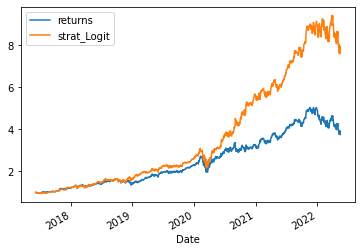

In [179]:
np.exp(df[['returns', 'strat_Logit']].cumsum()).plot()

### 3. Splitting train and test set

In [180]:
from sklearn.model_selection import train_test_split

In [181]:
train_data, test_data = train_test_split(df, shuffle=False, test_size=0.3, random_state=0)
train = train_data.copy()
test = test_data.copy()

### 4. Prediction

In [182]:
model = LogisticRegression()

In [183]:
model.fit(train[dirnames], train['direction'])

LogisticRegression()

In [196]:
test['prediction_Logit'] = model.predict(test[dirnames])
test['strat_Logit'] = test['prediction_Logit'] * test['returns']

In [197]:
np.exp(test[['returns', 'strat_Logit']].sum())

returns        1.211456
strat_Logit    1.231101
dtype: float64

<AxesSubplot:xlabel='Date'>

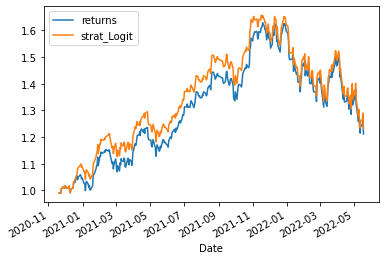

In [198]:
np.exp(test[['returns', 'strat_Logit']].cumsum()).plot()

### 4. Confussion Matrix and Classification report

In [187]:
from sklearn import metrics

In [188]:
metrics.confusion_matrix(test['direction'], test['prediction_Logit'])

array([[  6, 176],
       [  5, 188]], dtype=int64)

In [189]:
print(metrics.classification_report(test['direction'], test['prediction_Logit']))

              precision    recall  f1-score   support

          -1       0.55      0.03      0.06       182
           1       0.52      0.97      0.68       193

    accuracy                           0.52       375
   macro avg       0.53      0.50      0.37       375
weighted avg       0.53      0.52      0.38       375

